In [1]:
import sys

sys.path.append(r"C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\Logger")
sys.path.append(r"C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\DAQ")
sys.path.append(r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\Logger\logs\sessions')
sys.path.append(r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\Exceptions')
sys.path.append(r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\API')
sys.path.append(r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\API\SingleFreq')

import json
from DAQ import DAQ
from Acquisition_config import ACQUISITION_CONFIG
import logging
from logging.config import dictConfig
from SingleFreq.logs.logging_config import LOGGING_CONFIG 
from Exceptions import replace_non_serializable
from PAmodules.QuickSyn import FSL_0010
from PAmodules.network.RS_Signal_Generator import RS_SMA100B
import numpy as np
import niscope as ni
from PAmodules import Tools
from HDF5 import HDF5 as h5
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:

ip   = '192.168.40.15'   # Set IP address of SMA
devicename = 'PXI1Slot3' 
filepath = r'C:\\Users\\oper\\SynologyDrive\\Lab2023\\KIDs\\QTLab2324\\IRSource\\API\\SingleFreq\\png\\'

#===============================================================================================
#Import logger configuration
#===============================================================================================
dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
logger.info('START EXECUTION')

try:
    cfg1 = json.dumps(replace_non_serializable(ACQUISITION_CONFIG))
    logger.info('Dumping acquisition configuration')
    with open(ACQUISITION_CONFIG['acq_conf']['path'] + 'config.json','w') as f:
        f.write(cfg1)
except Exception:
    logger.critical('Dumping acquisition configuration')
    raise SystemError("Could not dump acquisition configuration!")

#===============================================================================================
#Acquire DAQ configuration dictionaries
#===============================================================================================

try:
    daq = DAQ()
    logger.info('DAQ class object correctly created')
except Exception:
    logger.critical('Could not crate DAQ class object')
    raise SyntaxError('Could not create DAQ class object')

try:
    fsl = FSL_0010.FSL10_synthesizer(device_address='COM36')
    logger.info('FSL_0010 class object correctly created')
except Exception:
    logger.critical('Could not crate FSL class object')
    raise SyntaxError('Could not create FSL class object')

try:
    sGen = RS_SMA100B.SMA100B(ip)
    logger.info('SMA class object correctly created')
except Exception:
    logger.critical('Could not crate SMA class object')
    raise SyntaxError('Could not create SMA class object')

19:23:59.127 - __main__ - <module> - INFO - START EXECUTION
19:23:59.129 - __main__ - <module> - INFO - Dumping acquisition configuration
19:23:59.131 - __main__ - <module> - INFO - DAQ class object correctly created
19:23:59.138 - __main__ - <module> - INFO - FSL_0010 class object correctly created
SMA100B: Connection successful!
19:23:59.229 - __main__ - <module> - INFO - SMA class object correctly created


In [3]:

LO =  8e9 
RF     = LO + 2e6
amplitude       = 17  
sample_rate     = 250e6
k               = 4
pulse_period    = k * 1e-6
num_points      = int(sample_rate * pulse_period)
percent         = 5
pulse_width     = pulse_period * (1-percent/100)
pulse_delay     = 0

channels = {'I'			: 0, 
            'Q'			: 1,
            'trigger'	: 3}

In [4]:
try:    
    sGen.reset()
    sGen.clear()
    sGen.RF_lvl_ampl(0)
    #sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)  
    #sGen.pul_gen_mode('SING')
    #sGen.pul_trig_mode('SING')
    logger.info('SMA set up correctly')
except Exception:
    logger.critical('Could not set up SMA')
    raise SystemError('Could not create SMA class object')


try:
    stat = daq.get_status
    logger.info('DAQ status: '+str(stat))
except Exception:
    logger.critical('Could not get DAQ status!')
    raise SystemError('Could not get DAQ status')

19:24:01.496 - __main__ - <module> - INFO - SMA set up correctly
19:24:01.498 - __main__ - <module> - INFO - DAQ status: <bound method DAQ.get_status of <DAQ.DAQ object at 0x0000000008C4A730>>


In [5]:
try:
    daq.reset_with_def()
    daq.get_status
    logger.info('Resetting DAQ with defaults')
except Exception:
    logger.error('Could not reset DAQ with defaults')
    pass
    #raise SystemError('Could not restet DAQ with defaults')

try:
    daq.acq_conf = ACQUISITION_CONFIG['acq_conf']
    logger.info('Inserting acquisition configuration from ACQUISITION_CONFIG dictionary')
except Exception:
    logger.warning('Coulkd not insert acquisition configuration')
    raise SystemError('Coulkd not insert acquisition configuration')

try:
    daq.horizontal_conf = ACQUISITION_CONFIG['horizontal']
    logger.info('Inserting hconf dic')
except Exception:
    logger.warning('Could not insert hconf dic')
    raise SystemError('Could not insert hconf dic')

try:
    daq.vertical_conf = ACQUISITION_CONFIG['vertical']
    logger.info('Inserting vconf dic')
except Exception:
    logger.warning('Could not insert vconf dic')
    raise SystemError('Could not insert vconf dic')

try:
    daq.chan_conf = ACQUISITION_CONFIG['chan_conf']
    logger.info('Inserting chan char dic')
except Exception:
    logger.warning('Could not insert chan char dic')
    raise SystemError('Could not insert chan char dic')

try:
    daq.trigger_dic = ACQUISITION_CONFIG['trigger']
    logger.info('Inserting trigger dic')
except Exception:
    logger.warning('Could not insert trigger dic')
    raise SystemError('Could not insert trigger dic')


19:24:01.569 - __main__ - <module> - ERROR - Could not reset DAQ with defaults
19:24:01.571 - __main__ - <module> - INFO - Inserting acquisition configuration from ACQUISITION_CONFIG dictionary
19:24:01.572 - __main__ - <module> - INFO - Inserting hconf dic
19:24:01.573 - __main__ - <module> - INFO - Inserting vconf dic
19:24:01.574 - __main__ - <module> - INFO - Inserting chan char dic
19:24:01.575 - __main__ - <module> - INFO - Inserting trigger dic


In [6]:
try:
    daq._session = ni.Session(devicename)
    logger.info('Creating new session!!!')
except Exception:
    logger.critical('Could not create new Niscope sesison')
    raise SystemError('Could not create new Niscope session')

try:
    if daq._session is not None:
        daq.config_trigger()
        logger.info('implementing trigger')
    else:
        pass
except Exception:
    logger.warning('Could not implement trigger')
    raise SystemError('Could not implement trigger')

19:24:02.302 - __main__ - <module> - INFO - Creating new session!!!
19:24:02.304 - __main__ - <module> - INFO - implementing trigger


In [7]:
try:
    logger.info(f'FSL is now outputting signal at {LO} GHz')
    fsl.set_frequency(LO) # GHz
    fsl.set_output('ON')
except Exception:
    logger.critical('FSL is not outputting signal!')

power = round(Tools.dBm_to_mVpk(amplitude))
logger.info('Setting SMA amplitude')

19:24:02.451 - __main__ - <module> - INFO - FSL is now outputting signal at 8000000000.0 GHz
19:24:02.454 - __main__ - <module> - INFO - Setting SMA amplitude


In [8]:
with daq._session as session:
    logger.info('Configuring channels')
    daq.configure_channels()
    logger.info('Executing trigger')
    sGen.RF_lvl_ampl(17)
    sGen.RF_freq(RF) 
    sGen.pul_state(1)
    sGen.RF_state(1)
    data = {'CH0': [],
            'CH1': [],
            'CH2': [],
            'CH3': []}
    wf_info = []
    try:
        daq._session.initiate()
        logger.info('Session initiated')
    except Exception:
        logger.critical('Could not initiate session')
    try:
        logger.info('Initiating fetching...')
        waveforms = session.channels[0,1].fetch()
        logger.info('Converting wfm[0] into dictionary')
        data['CH0'] = np.array(waveforms[0].samples.tolist())
        logger.info('Converting wfm[1] into dictionary')
        data['CH1'] = np.array(waveforms[1].samples.tolist()) 
    except Exception:
        logger.error('Could not fetch!!')
        sys.exit()

19:24:02.823 - __main__ - <module> - INFO - Configuring channels
19:24:02.827 - __main__ - <module> - INFO - Executing trigger
19:24:02.849 - __main__ - <module> - INFO - Session initiated
19:24:02.850 - __main__ - <module> - INFO - Initiating fetching...
19:24:02.868 - __main__ - <module> - INFO - Converting wfm[0] into dictionary
19:24:02.870 - __main__ - <module> - INFO - Converting wfm[1] into dictionary


In [9]:

try:
    hdf5 = h5.HDF5()
    path = r'C:\\Users\\oper\\SynologyDrive\\Lab2023\\KIDs\\QTLab2324\\IRSource\\API\\SingleFreq\\files\\'
    hdf5.name = 'Test2.hdf5'
    hdf5.dic = data
    hdf5.to_hdf5()
    logger.info('Transfering data from python dic to '+str(path+hdf5.name))
except Exception:
    logger.warning('Could not transfer data into '+str(path+hdf5.name))

Execution time: 0.07
19:24:03.326 - __main__ - <module> - INFO - Transfering data from python dic to C:\\Users\\oper\\SynologyDrive\\Lab2023\\KIDs\\QTLab2324\\IRSource\\API\\SingleFreq\\files\\Test2.hdf5


In [10]:
Q_max, Q_dic = find_peaks(data['CH0'], height=max(data['CH0']*6/10), threshold=None, distance=50)
I_max, I_dic = find_peaks(data['CH1'], height=max(data['CH1']*6/10), threshold=None, distance=50)

In [11]:
data['CH0'] = data['CH0'][:Q_max[-1]]
data['CH1'] = data['CH1'][:I_max[-1]]

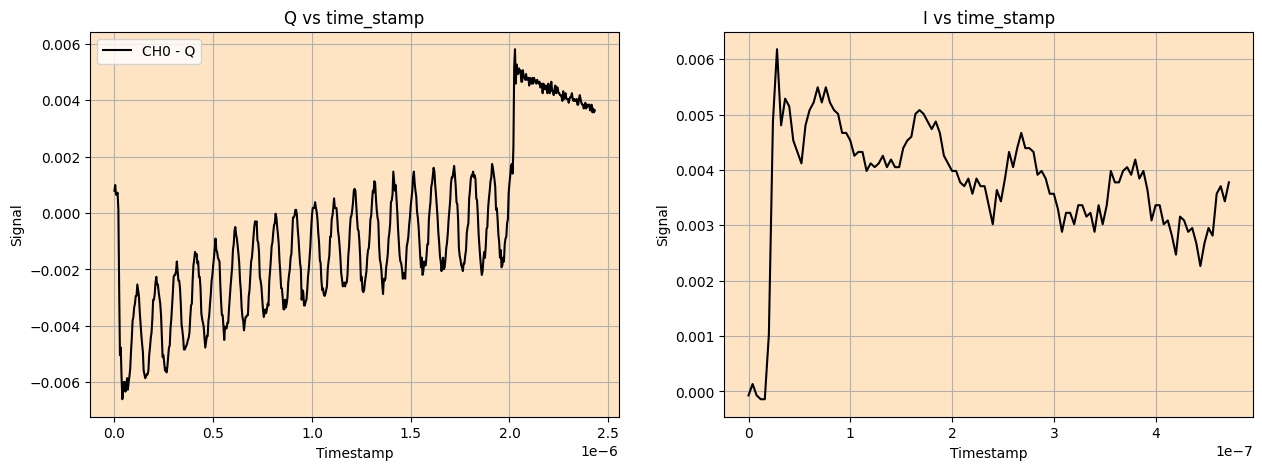

In [12]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
axs[0].plot(np.arange(len(data['CH0']))/sample_rate, data['CH0'], color='black', label='CH0 - Q')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Signal')
axs[0].set_title('Q vs time_stamp')
axs[0].set_facecolor('bisque')
axs[0].legend()
axs[0].grid()
axs[1].plot(np.arange(len(data['CH1']))/sample_rate, data['CH1'], color='black', label='CH1 - I')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Signal')
axs[1].set_title('I vs time_stamp')
axs[1].set_facecolor('bisque')
axs[1].grid()


In [13]:
if len(data['CH1'])<len(data['CH0']):
    idx = [i for i,_ in enumerate(data['CH1'])]
    data['CH0'] = [val for (i,val) in zip(idx, data['CH0'])]
else:
    idx = [i for i,_ in enumerate(data['CH0'])]
    data['CH1'] = [val for (i,val) in zip(idx, data['CH1'])]
print(len(data['CH0']))
print(len(data['CH1']))

119
119


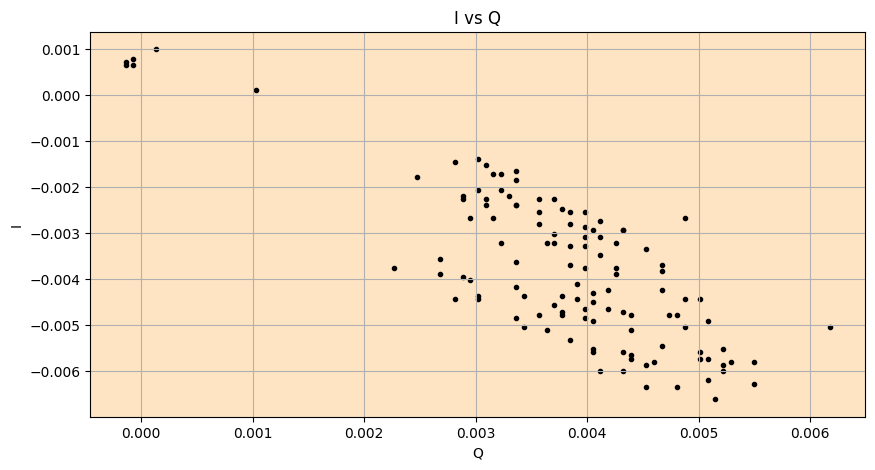

In [14]:
fig, axs = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(10)
axs.scatter(data['CH1'], data['CH0'], marker='.', color='black', label='I vs Q')
axs.set_xlabel('Q')
axs.set_ylabel('I')
axs.set_title('I vs Q')
axs.set_facecolor('bisque')
axs.grid()